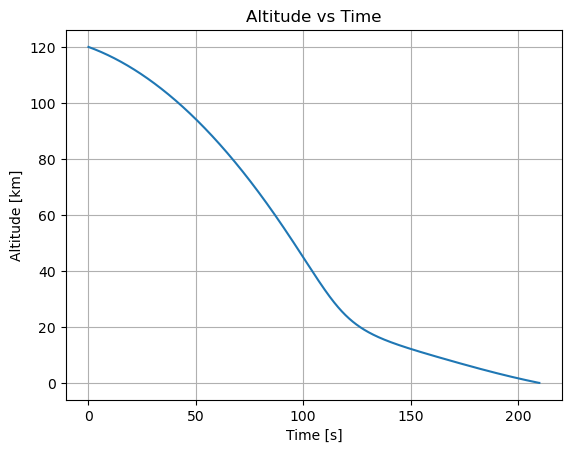

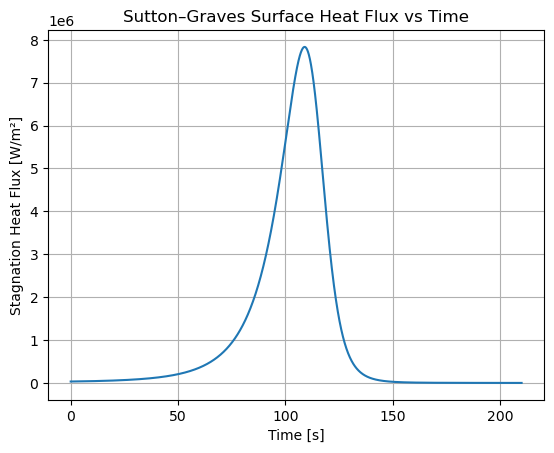

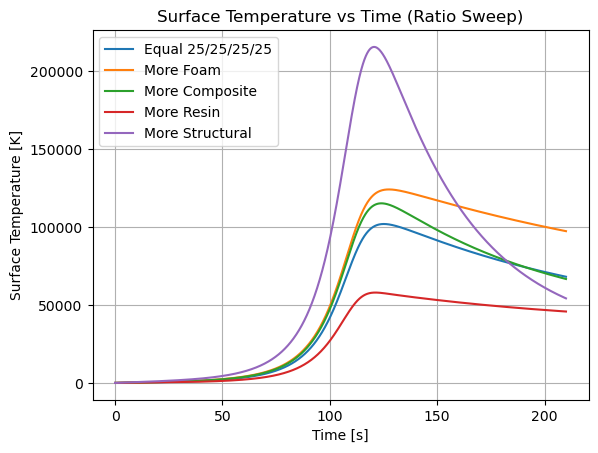

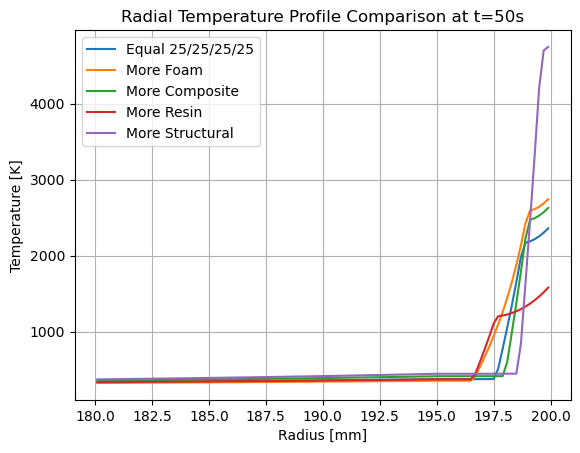

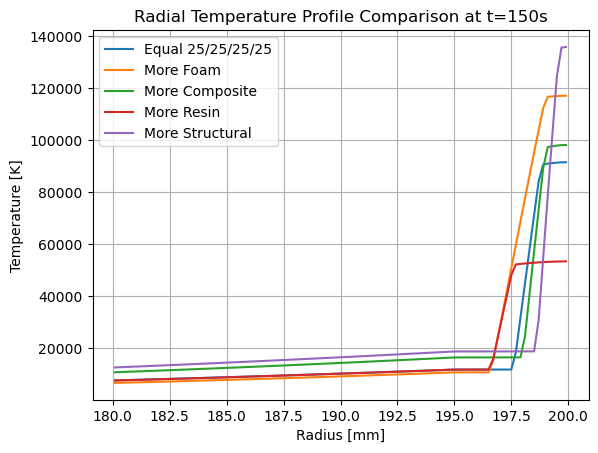

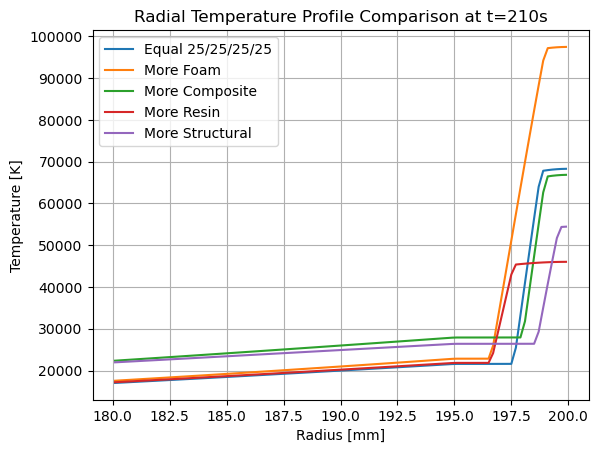

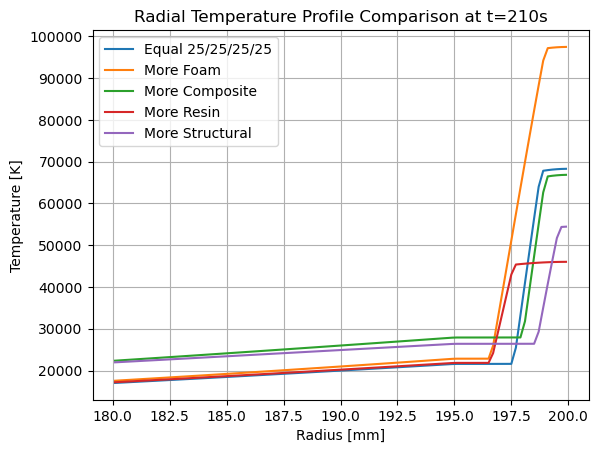

In [23]:
import numpy as np
import math as m
import matplotlib.pyplot as plt

# Physical constants
R_EARTH = 6371000.0
G0 = 9.81

# Atmosphere & gravity
def atmosphere_rho(h):
    rho0 = 1.225
    H = 7200.0
    h = np.maximum(h, 0.0)
    return rho0 * np.exp(-h / H)

def gravity(h):
    return G0 * (R_EARTH / (R_EARTH + np.maximum(h, 0.0)))**2

# Sutton–Graves heat flux
def sutton_graves_q(h, V, Rn, K=1.11e-4):
    rho = atmosphere_rho(h)
    return K * np.sqrt(rho) * np.abs(V)**3 / np.sqrt(Rn)

# Material database
MATERIAL_DB = {
    "Air":          dict(rho=1.2,    cp=1005.0, k=0.026),
    "Resin":        dict(rho=1440.0,  cp=1100.0, k=0.6),
    "Composite":    dict(rho=1800.0,  cp=710.0,  k=70.0),
    "Foam":         dict(rho=140.0,   cp=1000.0, k=0.015),
    "Structural":   dict(rho=2780.0,  cp=875.0,  k=121.0),
}

# Multilayer TPS builder (inner -> outer)
def compute_multilayer_TPS_layers(
    TPS_inner,
    TPS_outer,
    layer_ratios,
    layer_order=("Structural", "Composite", "Foam", "Resin"),

):
    if len(layer_ratios) != len(layer_order):
        raise ValueError("Number of layer ratios must match number of layers")

    if not np.isclose(sum(layer_ratios), 1.0):
        raise ValueError(f"Layer ratios must sum to 1.0, got {sum(layer_ratios):.6f}")

    layers = []

    air = MATERIAL_DB["Air"]
    layers.append((TPS_inner, air["rho"], air["cp"], air["k"]))

    total_thickness = TPS_outer - TPS_inner
    r_current = TPS_inner
    

    for ratio, mat_name in zip(layer_ratios, layer_order):
        thickness = ratio * total_thickness
        r_current += thickness
        mat = MATERIAL_DB[mat_name]
        layers.append((r_current, mat["rho"], mat["cp"], mat["k"]))

    # safety: force last radius exactly TPS_outer
    layers[-1] = (TPS_outer, layers[-1][1], layers[-1][2], layers[-1][3])
    return layers

# Material assignment (piecewise constant from center outward)
def assign_material_properties(r_centers, layers):
    rho = np.zeros_like(r_centers, dtype=float)
    cp  = np.zeros_like(r_centers, dtype=float)
    k   = np.zeros_like(r_centers, dtype=float)

    for i, ri in enumerate(r_centers):
        for r_outer, rh, c, kk in layers:
            if ri <= r_outer + 1e-15:
                rho[i], cp[i], k[i] = rh, c, kk
                break
        else:
            rho[i], cp[i], k[i] = layers[-1][1], layers[-1][2], layers[-1][3]
    return rho, cp, k

# Tridiagonal utilities
def apply_tridiag(a, b, c, x):
    y = b * x
    y[1:]  += a * x[:-1]
    y[:-1] += c * x[1:]
    return y

def thomas_solve(a, b, c, d):
    n = len(b)
    ac = a.astype(float).copy()
    bc = b.astype(float).copy()
    cc = c.astype(float).copy()
    dc = d.astype(float).copy()

    for i in range(1, n):
        w = ac[i-1] / bc[i-1]
        bc[i] -= w * cc[i-1]
        dc[i] -= w * dc[i-1]

    x = np.zeros(n, dtype=float)
    x[-1] = dc[-1] / bc[-1]
    for i in range(n-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x

# FV build: returns everything needed for CN updates
def build_spherical_fv_system(N, R, layers):
    dr = R / N

    r_faces   = np.linspace(0.0, R, N+1)
    r_centers = 0.5 * (r_faces[:-1] + r_faces[1:])

    A_faces = 4.0 * np.pi * r_faces**2
    V_cells = (4.0/3.0) * np.pi * (r_faces[1:]**3 - r_faces[:-1]**3)

    rho, cp, k_cell = assign_material_properties(r_centers, layers)

    # harmonic mean k at interior faces
    k_faces = np.zeros(N+1, dtype=float)
    k_faces[0] = k_cell[0]   # unused since A_faces[0]=0
    for j in range(1, N):
        kL, kR = k_cell[j-1], k_cell[j]
        k_faces[j] = 2.0 * kL * kR / (kL + kR)
    k_faces[N] = k_cell[-1]

    Gw = k_faces[:-1] * A_faces[:-1] / dr
    Ge = k_faces[1:]  * A_faces[1:]  / dr

    # surface face handled by flux forcing, not K
    Ge[-1] = 0.0

    K_diag  = -(Gw + Ge)
    K_lower = Gw[1:]
    K_upper = Ge[:-1]

    M_diag = rho * cp * V_cells

    return (r_centers, r_faces, dr, rho, cp, k_cell, V_cells, A_faces,
            M_diag, K_lower, K_diag, K_upper)

# CN FV time step
def trapezoid_step_fv(Tn, dt, M_diag, K_lower, K_diag, K_upper,
                      V_cells, A_faces, q_n, q_np1, qdot_n=None, qdot_np1=None):
    q_mid = 0.5 * (q_n + q_np1)

    # power forcing per cell
    f_mid = np.zeros_like(Tn)
    f_mid[-1] += q_mid * A_faces[-1]  # q>0 injects heat into solid

    if (qdot_n is not None) and (qdot_np1 is not None):
        qdot_mid = 0.5 * (qdot_n + qdot_np1)
        f_mid += qdot_mid * V_cells

    Kx = apply_tridiag(K_lower, K_diag, K_upper, Tn)
    RHS = M_diag * Tn + 0.5 * dt * Kx + dt * f_mid

    a = -0.5 * dt * K_lower
    b = M_diag - 0.5 * dt * K_diag
    c = -0.5 * dt * K_upper

    return thomas_solve(a, b, c, RHS)

def integrate_conduction_fv(T0, dt, q_array, system):
    (r_centers, r_faces, dr, rho, cp, k_cell, V_cells, A_faces,
     M_diag, K_lower, K_diag, K_upper) = system

    T = T0.copy()
    sol = [T.copy()]
    for n in range(len(q_array) - 1):
        T = trapezoid_step_fv(T, dt, M_diag, K_lower, K_diag, K_upper,
                              V_cells, A_faces, q_array[n], q_array[n+1])
        sol.append(T.copy())
    return np.array(sol)

# Reentry dynamics
def rk4(f, t, y, dt, *args):
    k1 = f(t, y, *args)
    k2 = f(t + dt/2, y + dt/2*k1, *args)
    k3 = f(t + dt/2, y + dt/2*k2, *args)
    k4 = f(t + dt,   y + dt*k3,   *args)
    return y + dt*(k1 + 2*k2 + 2*k3 + k4)/6

def reentry_rhs(t, y, m0, Cd, Aref):
    h, vx, vz = y
    h = max(h, 0.0)
    rho = atmosphere_rho(h)
    g = gravity(h)
    V = np.hypot(vx, vz)
    D = 0.0 if V < 1e-12 else 0.5*rho*V**2*Cd*Aref/m0
    ax = -D*vx/V if V > 0 else 0.0
    az = -g - D*vz/V if V > 0 else -g
    return np.array([vz, ax, az])

def integrate_reentry(y0):
    t = 0.0
    y = y0.copy()
    T_hist = [t]
    Y_hist = [y.copy()]
    while y[0] > 0.0 and t < t_final:
        y = rk4(reentry_rhs, t, y, dt, 200.0, 1.2, np.pi*R_sphere**2)
        y[0] = max(y[0], 0.0)
        t += dt
        T_hist.append(t)
        Y_hist.append(y.copy())
    return np.array(T_hist), np.array(Y_hist)

# Ratio sweep runner
def run_ratio_sweep(ratio_tests, make_profiles=True):
    # --- trajectory + heating ONCE ---
    y0 = np.array([Alt_0,
                   V_0*np.cos(np.radians(-2.0)),
                   V_0*np.sin(np.radians(-2.0))])

    times, Y = integrate_reentry(y0)
    altitudes = Y[:, 0]
    Vmag = np.linalg.norm(Y[:, 1:], axis=1)
    q_array = sutton_graves_q(altitudes, Vmag, R_sphere)
    

    # Plot trajectory once
    plt.figure()
    plt.plot(times, altitudes/1000)
    plt.xlabel("Time [s]")
    plt.ylabel("Altitude [km]")
    plt.title("Altitude vs Time")
    plt.grid(True)

    # plot heat flux once
    plt.figure()
    plt.plot(times, q_array)
    plt.xlabel("Time [s]")
    plt.ylabel("Stagnation Heat Flux [W/m²]")
    plt.title("Sutton–Graves Surface Heat Flux vs Time")
    plt.grid(True)


    # --- surface temperature comparison for all ratio sets ---
    plt.figure()
    results = []

    for label, ratios in ratio_tests:
        layers = compute_multilayer_TPS_layers(TPS_inner, TPS_outer, ratios)
        system = build_spherical_fv_system(N, R_sphere, layers)
        r_centers = system[0]

        sol_T = integrate_conduction_fv(np.ones(N)*300.0, dt, q_array, system)
        T_surface = sol_T[:, -1]

        results.append((label, ratios, r_centers, sol_T, T_surface))
        plt.plot(times, T_surface, label=label)

    plt.xlabel("Time [s]")
    plt.ylabel("Surface Temperature [K]")
    plt.title("Surface Temperature vs Time (Ratio Sweep)")
    plt.grid(True)
    plt.legend()

    # --- radial profiles (compare ratio cases at a few times) ---
    if make_profiles:
        times_to_plot = [50., 150., 250., 350.]
        idxs = [int(np.argmin(np.abs(times - tt))) for tt in times_to_plot]

        for tidx, tt in zip(idxs, times_to_plot):
            plt.figure()
            for (label, ratios, r_centers, sol_T, T_surface) in results:
                # plot only outer region if you want (same idea as your mask)
                r_mask = r_centers >= 0.180
                r_plot = r_centers[r_mask]
                T_plot = sol_T[tidx, r_mask]
                plt.plot(r_plot*1000, T_plot, label=label)

            plt.xlabel("Radius [mm]")
            plt.ylabel("Temperature [K]")
            plt.title(f"Radial Temperature Profile Comparison at t={times[tidx]:.0f}s")
            plt.grid(True)
            plt.legend()

    plt.show()

# Simulation / numerical parameters
R_sphere = 0.2
N = 1000
t_final = 400.0
dt = 0.1

TPS_inner = 0.195
TPS_outer = R_sphere

Alt_0 = 120000
V_0 = 8000

# Run
if __name__ == "__main__":

    # Ratio tests are for: (Structural, Composite, Foam, Resin)
    ratio_tests = [
        ("Equal 25/25/25/25", [0.25, 0.25, 0.25, 0.25]),
        ("More Foam",          [0.10, 0.20, 0.50, 0.20]),
        ("More Composite",     [0.10, 0.50, 0.20, 0.20]),
        ("More Resin",         [0.10, 0.20, 0.20, 0.50]),
        ("More Structural",    [0.50, 0.20, 0.20, 0.10]),
    ]

    run_ratio_sweep(ratio_tests, make_profiles=True)
